# Features extraction

In this file, the pre-trained model (https://github.com/csho33/bacteria-ID) is used as a features extractor.

## Librairies

In [1]:
from data_loader import load_data
import os, sys
import random
import numpy as np
import torch
from collections import OrderedDict
from extractor import Extractor
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from statistics import mean
from keras import Model
from keras import Input
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Pre-trained models
In this part, the three provided pre-trained models are load.

In [2]:
os.chdir(os.getcwd())
models_dir = 'Bacteria_TL'
sys.path.append(models_dir)

Now, the import can be completed, using the file provided in the Bacterial_TL directory

In [3]:
from training import get_predictions
from datasets import spectral_dataloader

In [4]:
models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']

## Dataset
This part is dedicated to the dataset. The data will be load and split into train, validation and test sets.

### Load data

In [5]:
X, Y, groups, _ = load_data()

### Split into train, validation and test sets
The split operation is doing as follow :
   - 60% of the patients data are take for the train set
   - 20% are take for the validation set
   - 20% are take for the test set

In [6]:
selected_groups = random.sample(range(0, 30), 30)
train_groups = selected_groups[:18]
validation_groups = selected_groups[18:24]
test_groups = selected_groups[24:]

In [7]:
def createSplit(X, Y, groups, groups_selected):
    X_split = []
    Y_split = []
    for i in range(len(X)):
        if(groups[i] in groups_selected):
            X_split.append(X[i])
            Y_split.append(Y[i])
    return np.array(X_split), np.array(Y_split)

In [8]:
X_train, Y_train = createSplit(X, Y, groups, train_groups)
X_validation, Y_validation = createSplit(X, Y, groups, validation_groups)
X_test, Y_test = createSplit(X, Y, groups, test_groups)

## Features extractors
This is the part where the different models are modified in order to be used as features extractor.

### Pre-trained models parameters
General parameters of pre-trained models are defined here.

In [9]:
base_layers = 6
hidden_size = 100
block_size = 2
input_dim = 1174
in_channels = 64
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()
base_to_remove = ['linear.weight', 'linear.bias']

### Utility functions

In [10]:
def removekey(d, block):
    r = dict(d)
    copy = r.copy()
    toRemove = [base_to_remove]
    if block != 0:
        toRemove.append('encoder.5')
    if block == 2:
        toRemove.append('encoder.4')
    
    for key in copy.keys():
        if (key in toRemove[0]):
            r.pop(key)
        if len(toRemove) > 1:
            if key.startswith(toRemove[1]):
                r.pop(key)
        if len(toRemove) == 3:
            if key.startswith(toRemove[2]):
                r.pop(key)
        
    return OrderedDict(r)

In [11]:
def load_model(modelToLoad, numberOfBlockToRemove):
    layers = base_layers - numberOfBlockToRemove
    hidden_sizes = [hidden_size] * layers
    num_blocks = [block_size] * layers
    model = Extractor(hidden_sizes, num_blocks)
    
    if cuda: model.cuda()
    
    checkpoint = torch.load(models_dir + '/' + modelToLoad, map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, numberOfBlockToRemove)
    model.load_state_dict(mod_weights, strict=True)
    
    return model, mod_weights, checkpoint

### First experiment
Each pre-trained model is transformed in features extractor removing the final linear layer. 

#### "Pretrained model"

In [12]:
pretrainedNoLinear, _, _ = load_model(models[0], 0)

In [13]:
print(pretrainedNoLinear)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Finetuned model"

In [14]:
finetunedNoLinear, _, _ = load_model(models[1], 0)

In [15]:
print(finetunedNoLinear)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Clinical model"

In [16]:
clinicalNoLinear, _, _ = load_model(models[2], 0)

In [17]:
print(clinicalNoLinear)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

### Second experiment
Each pre-trained model is now transformed removing the last block of the original model.

#### "Pretrained model"

In [18]:
pretrainedNoLastBlock, _, _ = load_model(models[0], 1)

In [19]:
print(pretrainedNoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Finetuned model"

In [20]:
finetunedNoLastBlock, _, _ = load_model(models[1], 1)

In [21]:
print(finetunedNoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Clinical model"

In [22]:
clinicalNoLastBlock, _, _ = load_model(models[2], 1)

In [23]:
print(clinicalNoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

### Third experiment
Each pre-trained model is now transformed removing the last two blocks.

#### "Pretrained model"

In [24]:
pretrainedNoTwoLastBlock, _, _ = load_model(models[0], 2)

In [25]:
print(pretrainedNoTwoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Finetuned model"

In [26]:
finetunedNoTwoLastBlock, _, _ = load_model(models[1], 2)

In [27]:
print(finetunedNoTwoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

#### "Clinical model"

In [28]:
clinicalNoTwoLastBlock, _, _ = load_model(models[2], 2)

In [29]:
print(clinicalNoTwoLastBlock)

Extractor(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv1d(64, 100, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (bn1): BatchNorm1d(100, eps=

## Features extraction
The features extractor created in the previous part are now going to be used.

In [30]:
dl_train = spectral_dataloader(X_train, Y_train, batch_size=10, shuffle=False)
dl_validation = spectral_dataloader(X_validation, Y_validation, batch_size=10, shuffle=False)
dl_test = spectral_dataloader(X_test, Y_test, batch_size=10, shuffle=False)

### Utility function

In [31]:
def groupFeatures(X, features):
    size = len(X)
    numFeatures = len(features)
    groupSize = numFeatures//size
    X_grouped = []
    num = 1
    tmp = []
    for i in range(numFeatures):
        if num > groupSize:
            num = 1
        if num == 1:
            tmp = []
        tmp.append(features[i])
        if num == groupSize:
            X_grouped.append(tmp)
        num+=1

    return X_grouped

### First category of extractors

In [32]:
#Train set & pretrainedNoLinear
t0 = time()
featuresPretrained1_train = get_predictions(pretrainedNoLinear, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained1_train)//len(X_train), time()-t0))
featuresPretrained1_train = groupFeatures(X_train, featuresPretrained1_train)
featuresPretrained1_train = np.array(featuresPretrained1_train)

#Validation set & pretrainedNoLinear
t0 = time()
featuresPretrained1_validation = get_predictions(pretrainedNoLinear, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained1_validation)//len(X_validation), time()-t0))
featuresPretrained1_validation = groupFeatures(X_validation, featuresPretrained1_validation)
featuresPretrained1_validation = np.array(featuresPretrained1_validation)

#Test set & pretrainedNoLinear
t0 = time()
featuresPretrained1_test = get_predictions(pretrainedNoLinear, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained1_test)//len(X_test), time()-t0))
featuresPretrained1_test = groupFeatures(X_test, featuresPretrained1_test)
featuresPretrained1_test = np.array(featuresPretrained1_test)

Predicted 37 features for each spectrum: 14.62s
Predicted 37 features for each spectrum: 11.10s
Predicted 37 features for each spectrum: 6.40s


In [33]:
#Train set & finetunedNoLinear
t0 = time()
featuresFinetuned1_train = get_predictions(finetunedNoLinear, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned1_train)//len(X_train), time()-t0))
featuresFinetuned1_train = groupFeatures(X_train, featuresFinetuned1_train)
featuresFinetuned1_train = np.array(featuresFinetuned1_train)

#Validation set & finetunedNoLinear
t0 = time()
featuresFinetuned1_validation = get_predictions(finetunedNoLinear, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned1_validation)//len(X_validation), time()-t0))
featuresFinetuned1_validation = groupFeatures(X_validation, featuresFinetuned1_validation)
featuresFinetuned1_validation = np.array(featuresFinetuned1_validation)

#Test set & finetunedNoLinear
t0 = time()
featuresFinetuned1_test = get_predictions(finetunedNoLinear, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned1_test)//len(X_test), time()-t0))
featuresFinetuned1_test = groupFeatures(X_test, featuresFinetuned1_test)
featuresFinetuned1_test = np.array(featuresFinetuned1_test)

Predicted 37 features for each spectrum: 17.43s
Predicted 37 features for each spectrum: 12.33s
Predicted 37 features for each spectrum: 6.37s


In [34]:
#Train set & clinicalNoLinear
t0 = time()
featuresClinical1_train = get_predictions(clinicalNoLinear, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical1_train)//len(X_train), time()-t0))
featuresClinical1_train = groupFeatures(X_train, featuresClinical1_train)
featuresClinical1_train = np.array(featuresClinical1_train)

#Validation set & clinicalNoLinear
t0 = time()
featuresClinical1_validation = get_predictions(clinicalNoLinear, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical1_validation)//len(X_validation), time()-t0))
featuresClinical1_validation = groupFeatures(X_validation, featuresClinical1_validation)
featuresClinical1_validation = np.array(featuresClinical1_validation)

#Test set & clinicalNoLinear
t0 = time()
featuresClinical1_test = get_predictions(clinicalNoLinear, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical1_test)//len(X_test), time()-t0))
featuresClinical1_test = groupFeatures(X_test, featuresClinical1_test)
featuresClinical1_test = np.array(featuresClinical1_test)

Predicted 37 features for each spectrum: 12.65s
Predicted 37 features for each spectrum: 12.10s
Predicted 37 features for each spectrum: 5.64s


### Second category of extractors

In [35]:
#Train set & pretrainedNoLastBlock
t0 = time()
featuresPretrained2_train = get_predictions(pretrainedNoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained2_train)//len(X_train), time()-t0))
featuresPretrained2_train = groupFeatures(X_train, featuresPretrained2_train)
featuresPretrained2_train = np.array(featuresPretrained2_train)

#Validation set & pretrainedNoLastBlock
t0 = time()
featuresPretrained2_validation = get_predictions(pretrainedNoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained2_validation)//len(X_validation), time()-t0))
featuresPretrained2_validation = groupFeatures(X_validation, featuresPretrained2_validation)
featuresPretrained2_validation = np.array(featuresPretrained2_validation)

#Test set & pretrainedNoLastBlock
t0 = time()
featuresPretrained2_test = get_predictions(pretrainedNoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained2_test)//len(X_test), time()-t0))
featuresPretrained2_test = groupFeatures(X_test, featuresPretrained2_test)
featuresPretrained2_test = np.array(featuresPretrained2_test)

Predicted 74 features for each spectrum: 14.20s
Predicted 74 features for each spectrum: 8.17s
Predicted 74 features for each spectrum: 6.15s


In [36]:
#Train set & finetunedNoLastBlock
t0 = time()
featuresFinetuned2_train = get_predictions(finetunedNoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned2_train)//len(X_train), time()-t0))
featuresFinetuned2_train = groupFeatures(X_train, featuresFinetuned2_train)
featuresFinetuned2_train = np.array(featuresFinetuned2_train)

#Validation set & finetunedNoLastBlock
t0 = time()
featuresFinetuned2_validation = get_predictions(finetunedNoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned2_validation)//len(X_validation), time()-t0))
featuresFinetuned2_validation = groupFeatures(X_validation, featuresFinetuned2_validation)
featuresFinetuned2_validation = np.array(featuresFinetuned2_validation)

#Test set & finetunedNoLastBlock
t0 = time()
featuresFinetuned2_test = get_predictions(finetunedNoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned2_test)//len(X_test), time()-t0))
featuresFinetuned2_test = groupFeatures(X_test, featuresFinetuned2_test)
featuresFinetuned2_test = np.array(featuresFinetuned2_test)

Predicted 74 features for each spectrum: 14.78s
Predicted 74 features for each spectrum: 11.68s
Predicted 74 features for each spectrum: 10.91s


In [37]:
#Train set & clinicalNoLastBlock
t0 = time()
featuresClinical2_train = get_predictions(clinicalNoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical2_train)//len(X_train), time()-t0))
featuresClinical2_train = groupFeatures(X_train, featuresClinical2_train)
featuresClinical2_train = np.array(featuresClinical2_train)

#Validation set & clinicalNoLastBlock
t0 = time()
featuresClinical2_validation = get_predictions(clinicalNoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical2_validation)//len(X_validation), time()-t0))
featuresClinical2_validation = groupFeatures(X_validation, featuresClinical2_validation)
featuresClinical2_validation = np.array(featuresClinical2_validation)

#Test set & clinicalNoLastBlock
t0 = time()
featuresClinical2_test = get_predictions(clinicalNoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical2_test)//len(X_test), time()-t0))
featuresClinical2_test = groupFeatures(X_test, featuresClinical2_test)
featuresClinical2_test = np.array(featuresClinical2_test)

Predicted 74 features for each spectrum: 16.04s
Predicted 74 features for each spectrum: 8.19s
Predicted 74 features for each spectrum: 5.91s


### Third category of extractors

In [38]:
#Train set & pretrainedNoTwoLastBlock
t0 = time()
featuresPretrained3_train = get_predictions(pretrainedNoTwoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained3_train)//len(X_train), time()-t0))
featuresPretrained3_train = groupFeatures(X_train, featuresPretrained3_train)
featuresPretrained3_train = np.array(featuresPretrained3_train)

#Validation set & pretrainedNoTwoLastBlock
t0 = time()
featuresPretrained3_validation = get_predictions(pretrainedNoTwoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained3_validation)//len(X_validation), time()-t0))
featuresPretrained3_validation = groupFeatures(X_validation, featuresPretrained3_validation)
featuresPretrained3_validation = np.array(featuresPretrained3_validation)

#Test set & pretrainedNoTwoLastBlock
t0 = time()
featuresPretrained3_test = get_predictions(pretrainedNoTwoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresPretrained3_test)//len(X_test), time()-t0))
featuresPretrained3_test = groupFeatures(X_test, featuresPretrained3_test)
featuresPretrained3_test = np.array(featuresPretrained3_test)

Predicted 147 features for each spectrum: 19.15s
Predicted 147 features for each spectrum: 7.84s
Predicted 147 features for each spectrum: 5.47s


In [39]:
#Train set & finetunedNoTwoLastBlock
t0 = time()
featuresFinetuned3_train = get_predictions(finetunedNoTwoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned3_train)//len(X_train), time()-t0))
featuresFinetuned3_train = groupFeatures(X_train, featuresFinetuned3_train)
featuresFinetuned3_train = np.array(featuresFinetuned3_train)

#Validation set & finetunedNoTwoLastBlock
t0 = time()
featuresFinetuned3_validation = get_predictions(finetunedNoTwoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned3_validation)//len(X_validation), time()-t0))
featuresFinetuned3_validation = groupFeatures(X_validation, featuresFinetuned3_validation)
featuresFinetuned3_validation = np.array(featuresFinetuned3_validation)

#Test set & finetunedNoTwoLastBlock
t0 = time()
featuresFinetuned3_test = get_predictions(finetunedNoTwoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresFinetuned3_test)//len(X_test), time()-t0))
featuresFinetuned3_test = groupFeatures(X_test, featuresFinetuned3_test)
featuresFinetuned3_test = np.array(featuresFinetuned3_test)

Predicted 147 features for each spectrum: 19.65s
Predicted 147 features for each spectrum: 10.99s
Predicted 147 features for each spectrum: 15.50s


In [40]:
#Train set & clinicalNoTwoLastBlock
t0 = time()
featuresClinical3_train = get_predictions(clinicalNoTwoLastBlock, dl_train, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical3_train)//len(X_train), time()-t0))
featuresClinical3_train = groupFeatures(X_train, featuresClinical3_train)
featuresClinical3_train = np.array(featuresClinical3_train)

#Validation set & clinicalNoTwoLastBlock
t0 = time()
featuresClinical3_validation = get_predictions(clinicalNoTwoLastBlock, dl_validation, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical3_validation)//len(X_validation), time()-t0))
featuresClinical3_validation = groupFeatures(X_validation, featuresClinical3_validation)
featuresClinical3_validation = np.array(featuresClinical3_validation)

#Test set & clinicalNoTwoLastBlock
t0 = time()
featuresClinical3_test = get_predictions(clinicalNoTwoLastBlock, dl_test, cuda)
print('Predicted {} features for each spectrum: {:0.2f}s'.format(len(featuresClinical3_test)//len(X_test), time()-t0))
featuresClinical3_test = groupFeatures(X_test, featuresClinical3_test)
featuresClinical3_test = np.array(featuresClinical3_test)

Predicted 147 features for each spectrum: 33.93s
Predicted 147 features for each spectrum: 7.15s
Predicted 147 features for each spectrum: 4.91s


## Predict using "classical" model: Decision Tree Classifier
The extracted features are passed to a classical model.

### Utility function

In [41]:
def predictWithDTC(X_train, Y_train, X_validation, Y_validation, X_test, Y_test):
    model = DecisionTreeClassifier()
    model = model.fit(X_train, Y_train)
    val_score = cross_val_score(model, X_validation, Y_validation, scoring='accuracy')
    prediction = model.predict(X_test)
    accuracy_test = accuracy_score(Y_test, prediction)
    return val_score, accuracy_test

### With features from first category of extractor

In [42]:
val_score_pretrained1, accuracy_score_pretrained1 = predictWithDTC(featuresPretrained1_train, Y_train, featuresPretrained1_validation, Y_validation, featuresPretrained1_test, Y_test)
print('Using simple pretrained model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_pretrained1), accuracy_score_pretrained1))

Using simple pretrained model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.78333


In [43]:
val_score_finetuned1, accuracy_score_finetuned1 = predictWithDTC(featuresFinetuned1_train, Y_train, featuresFinetuned1_validation, Y_validation, featuresFinetuned1_test, Y_test)
print('Using fituned model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_finetuned1), accuracy_score_finetuned1))

Using fituned model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.80000


In [44]:
val_score_clinical1, accuracy_score_clinical1 = predictWithDTC(featuresClinical1_train, Y_train, featuresClinical1_validation, Y_validation, featuresClinical1_test, Y_test)
print('Using clinical model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_clinical1), accuracy_score_clinical1))

Using clinical model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.68333


### With features from second category of extractors

In [45]:
val_score_pretrained2, accuracy_score_pretrained2 = predictWithDTC(featuresPretrained2_train, Y_train, featuresPretrained2_validation, Y_validation, featuresPretrained2_test, Y_test)
print('Using simple pretrained model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_pretrained2), accuracy_score_pretrained2))

Using simple pretrained model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.90000


In [46]:
val_score_finetuned2, accuracy_score_finetuned2 = predictWithDTC(featuresFinetuned2_train, Y_train, featuresFinetuned2_validation, Y_validation, featuresFinetuned2_test, Y_test)
print('Using fituned model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_finetuned2), accuracy_score_finetuned2))

Using fituned model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.81667


In [47]:
val_score_clinical2, accuracy_score_clinical2 = predictWithDTC(featuresClinical2_train, Y_train, featuresClinical2_validation, Y_validation, featuresClinical2_test, Y_test)
print('Using clinical model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_clinical2), accuracy_score_clinical2))

Using clinical model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.73333


### With features from third category of extractors

In [48]:
val_score_pretrained3, accuracy_score_pretrained3 = predictWithDTC(featuresPretrained3_train, Y_train, featuresPretrained3_validation, Y_validation, featuresPretrained3_test, Y_test)
print('Using simple pretrained model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_pretrained3), accuracy_score_pretrained3))

Using simple pretrained model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.68333


In [49]:
val_score_finetuned3, accuracy_score_finetuned3 = predictWithDTC(featuresFinetuned3_train, Y_train, featuresFinetuned3_validation, Y_validation, featuresFinetuned3_test, Y_test)
print('Using fituned model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_finetuned3), accuracy_score_finetuned3))

Using fituned model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.58333


In [50]:
val_score_clinical3, accuracy_score_clinical3 = predictWithDTC(featuresClinical3_train, Y_train, featuresClinical3_validation, Y_validation, featuresClinical3_test, Y_test)
print('Using clinical model as features etractor:\n\tAccuracy obtained on validation set: {:0.5f}\n\tAccuracy obtained on test set: {:0.5f}'.format(mean(val_score_clinical3), accuracy_score_clinical3))

Using clinical model as features etractor:
	Accuracy obtained on validation set: 1.00000
	Accuracy obtained on test set: 0.78333


## Predict using a deeper model
The features extracted are now passed to a deeper model.

### Utility functions

In [51]:
def createModel(inputShape):
    inputs = Input(shape = inputShape)
    x = layers.Dense(128, activation = 'relu')(inputs)
    x = layers.Dense(64, activation = 'relu') (x)
    x = layers.Dense(32, activation = 'relu') (x)
    x = layers.Dense(16, activation = 'relu') (x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation = 'sigmoid') (x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3, beta_1=0.5), metrics=["accuracy"])
    return model

In [52]:
def plotTrainResult(history, modelName):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], 'g')
    plt.plot(history.history['accuracy'], 'go')
    plt.title('Loss and accuracy obtain on the training set using ' + modelName)
    plt.ylim(0, 2)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

In [53]:
def plotValResult(history, modelName):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['val_loss'], 'r')
    plt.plot(history.history['val_accuracy'], 'ro')
    plt.title('Loss and accuracy obtain on the validation set using ' + modelName)
    plt.ylim(0, 2)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'])
    plt.show()

### Creation of models
- 1. From first category:

In [54]:
modelCategory1Pretrained = createModel(featuresPretrained1_train.shape[1:])

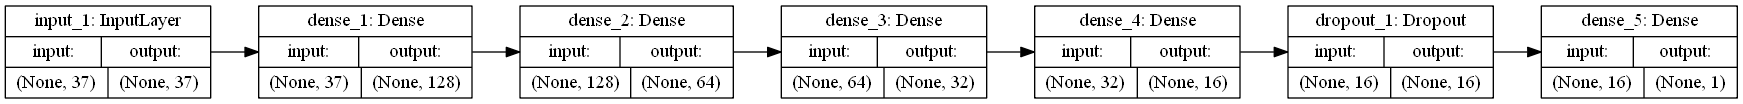

In [55]:
plot_model(modelCategory1Pretrained, show_shapes=True, show_layer_names=True, rankdir='LR')

In [56]:
modelCategory1Finetuned = createModel(featuresFinetuned1_train.shape[1:])

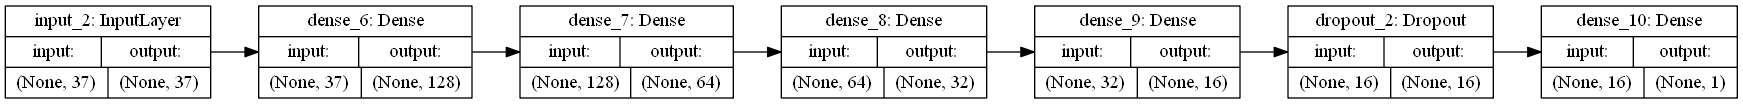

In [57]:
plot_model(modelCategory1Finetuned, show_shapes=True, show_layer_names=True, rankdir='LR')

In [58]:
modelCategory1Clinical = createModel(featuresClinical1_train.shape[1:])

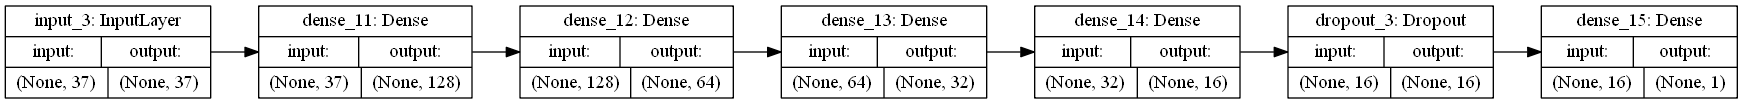

In [59]:
plot_model(modelCategory1Clinical, show_shapes=True, show_layer_names=True, rankdir='LR')

- 2. From second category:

In [60]:
modelCategory2Pretrained = createModel(featuresPretrained2_train.shape[1:])

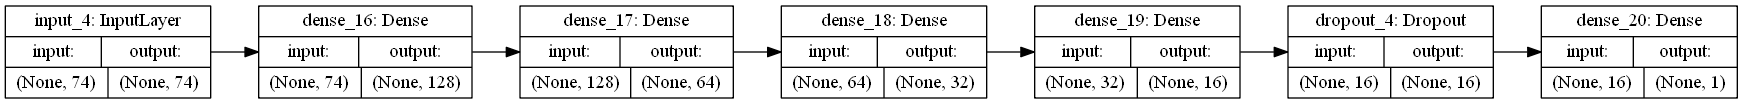

In [61]:
plot_model(modelCategory2Pretrained, show_shapes=True, show_layer_names=True, rankdir='LR')

In [62]:
modelCategory2Finetuned = createModel(featuresFinetuned2_train.shape[1:])

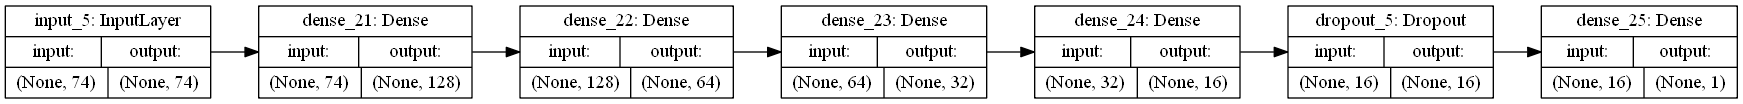

In [63]:
plot_model(modelCategory2Finetuned, show_shapes=True, show_layer_names=True, rankdir='LR')

In [64]:
modelCategory2Clinical = createModel(featuresClinical2_train.shape[1:])

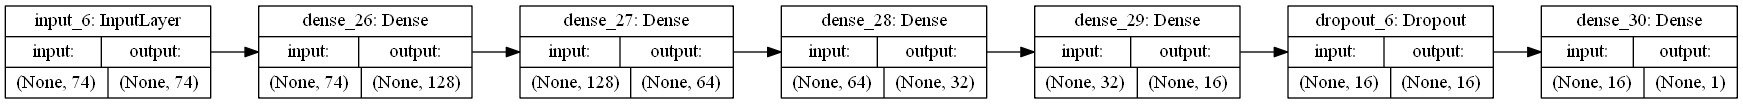

In [65]:
plot_model(modelCategory2Clinical, show_shapes=True, show_layer_names=True, rankdir='LR')

- 3. From third category:

In [66]:
modelCategory3Pretrained = createModel(featuresPretrained3_train.shape[1:])

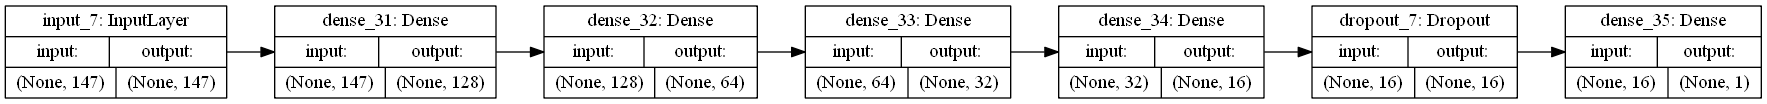

In [67]:
plot_model(modelCategory3Pretrained, show_shapes=True, show_layer_names=True, rankdir='LR')

In [68]:
modelCategory3Finetuned = createModel(featuresFinetuned3_train.shape[1:])

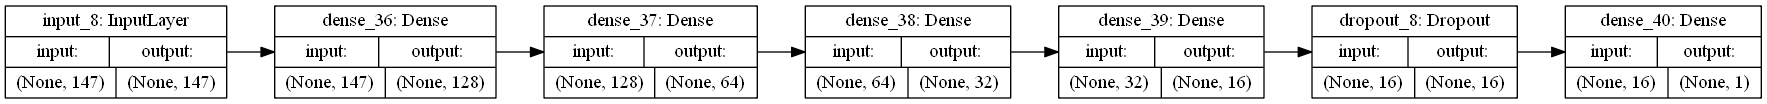

In [69]:
plot_model(modelCategory3Finetuned, show_shapes=True, show_layer_names=True, rankdir='LR')

In [70]:
modelCategory3Clinical = createModel(featuresClinical3_train.shape[1:])

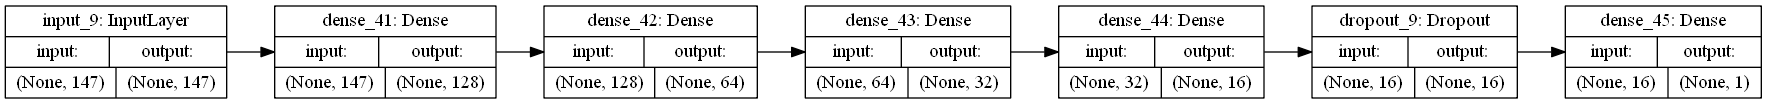

In [71]:
plot_model(modelCategory3Clinical, show_shapes=True, show_layer_names=True, rankdir='LR')

### Training

In [72]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=0)

In [73]:
batch_size=32
epochs=100

- 1. Models of first category:

    - Pretrained:

In [74]:
modelCategory1Pretrained_checkpoint_filepath = "checkpoints/checkpointCategory1Pretrained"
modelCategory1Pretrained_checkpoint_callback = ModelCheckpoint(filepath=modelCategory1Pretrained_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [75]:
historyCategory1Pretrained = modelCategory1Pretrained.fit(featuresPretrained1_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory1Pretrained_checkpoint_callback],
          validation_data=(featuresPretrained1_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

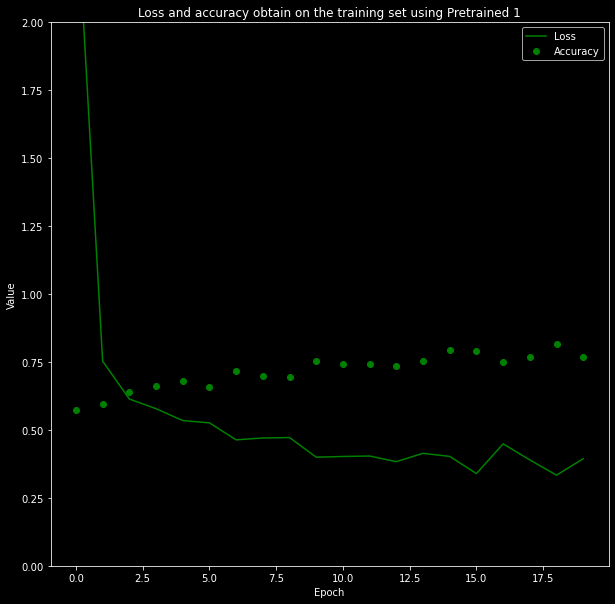

In [76]:
plotTrainResult(historyCategory1Pretrained, "Pretrained 1")

<Figure size 720x504 with 0 Axes>

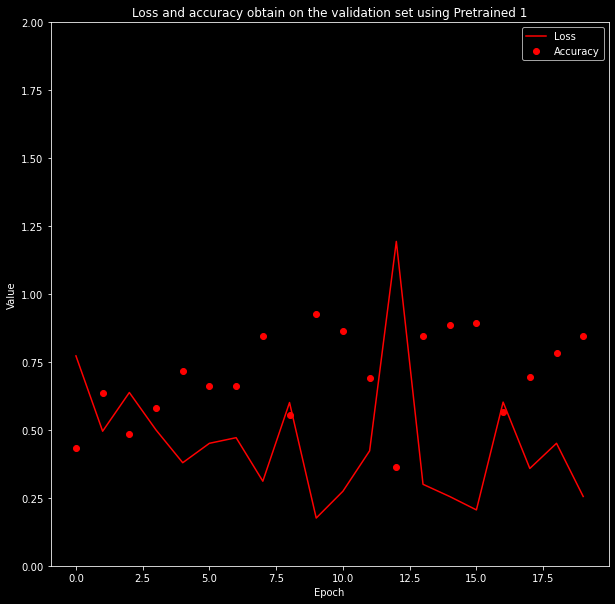

In [77]:
plotValResult(historyCategory1Pretrained, "Pretrained 1")

In [78]:
modelCategory1Pretrained.load_weights(modelCategory1Pretrained_checkpoint_filepath)

    - Finetuned:

In [79]:
modelCategory1Finetuned_checkpoint_filepath = "checkpoints/checkpointCategory1Finetuned"
modelCategory1Finetuned_checkpoint_callback = ModelCheckpoint(filepath=modelCategory1Finetuned_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [80]:
historyCategory1Finetuned = modelCategory1Finetuned.fit(featuresFinetuned1_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory1Finetuned_checkpoint_callback],
          validation_data=(featuresFinetuned1_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

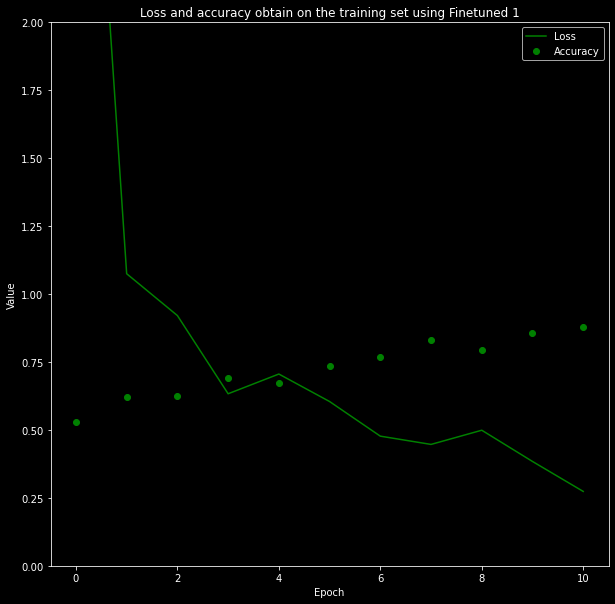

In [81]:
plotTrainResult(historyCategory1Finetuned, "Finetuned 1")

<Figure size 720x504 with 0 Axes>

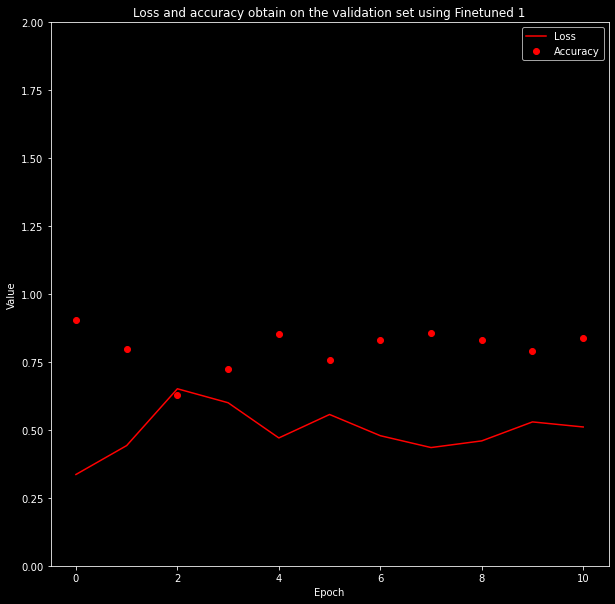

In [82]:
plotValResult(historyCategory1Finetuned, "Finetuned 1")

In [83]:
modelCategory1Finetuned.load_weights(modelCategory1Finetuned_checkpoint_filepath)

     - Clinical:

In [84]:
modelCategory1Clinical_checkpoint_filepath = "checkpoints/checkpointCategory1Clinical"
modelCategory1Clinical_checkpoint_callback = ModelCheckpoint(filepath=modelCategory1Clinical_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [85]:
historyCategory1Clinical = modelCategory1Clinical.fit(featuresClinical1_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory1Clinical_checkpoint_callback],
          validation_data=(featuresClinical1_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

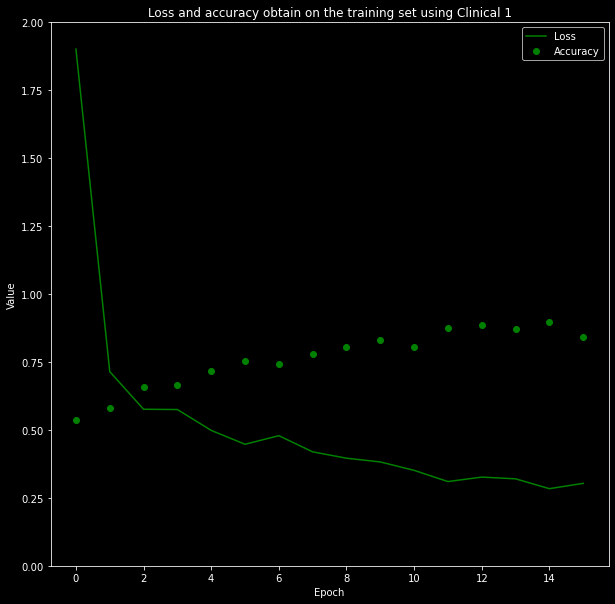

In [86]:
plotTrainResult(historyCategory1Clinical, "Clinical 1")

<Figure size 720x504 with 0 Axes>

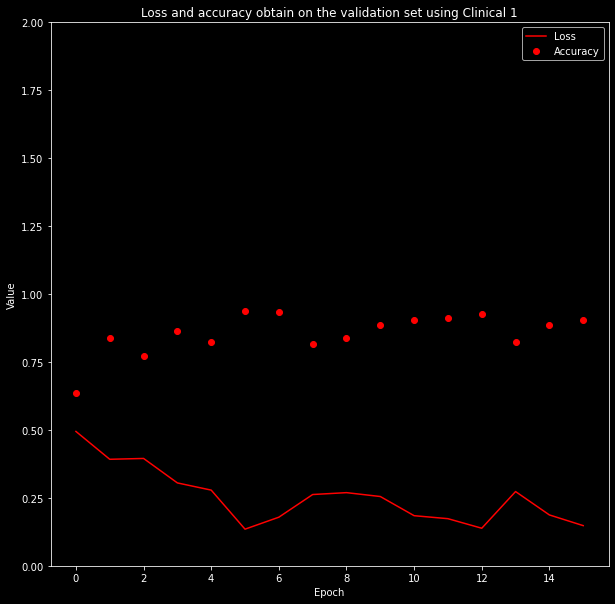

In [87]:
plotValResult(historyCategory1Clinical, "Clinical 1")

In [88]:
modelCategory1Clinical.load_weights(modelCategory1Clinical_checkpoint_filepath)

- 2. Models of second category:

    - Pretrained:

In [89]:
modelCategory2Pretrained_checkpoint_filepath = "checkpoints/checkpointCategory2Pretrained"
modelCategory2Pretrained_checkpoint_callback = ModelCheckpoint(filepath=modelCategory2Pretrained_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [90]:
historyCategory2Pretrained = modelCategory2Pretrained.fit(featuresPretrained2_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory2Pretrained_checkpoint_callback],
          validation_data=(featuresPretrained2_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

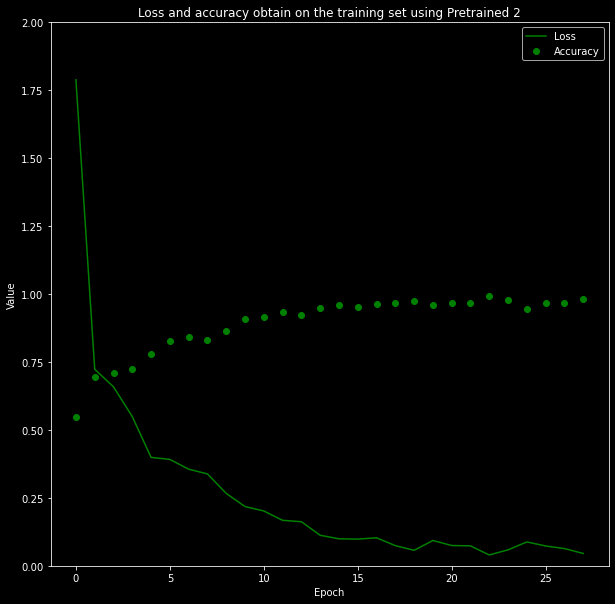

In [91]:
plotTrainResult(historyCategory2Pretrained, "Pretrained 2")

<Figure size 720x504 with 0 Axes>

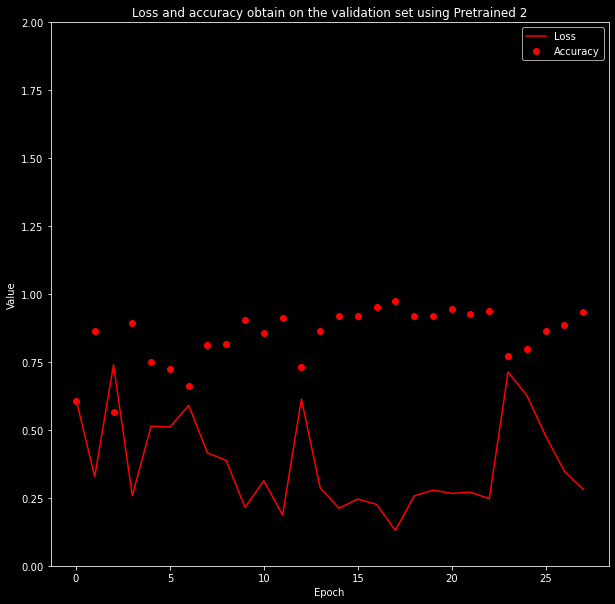

In [92]:
plotValResult(historyCategory2Pretrained, "Pretrained 2")

In [93]:
modelCategory2Pretrained.load_weights(modelCategory2Pretrained_checkpoint_filepath)

    - Finetuned:

In [94]:
modelCategory2Finetuned_checkpoint_filepath = "checkpoints/checkpointCategory2Finetuned"
modelCategory2Finetuned_checkpoint_callback = ModelCheckpoint(filepath=modelCategory2Finetuned_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [95]:
historyCategory2Finetuned = modelCategory2Finetuned.fit(featuresFinetuned2_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory2Finetuned_checkpoint_callback],
          validation_data=(featuresFinetuned2_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

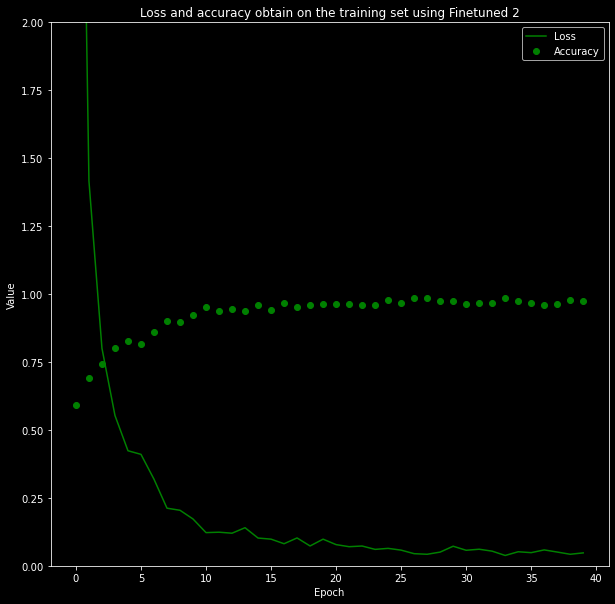

In [96]:
plotTrainResult(historyCategory2Finetuned, "Finetuned 2")

<Figure size 720x504 with 0 Axes>

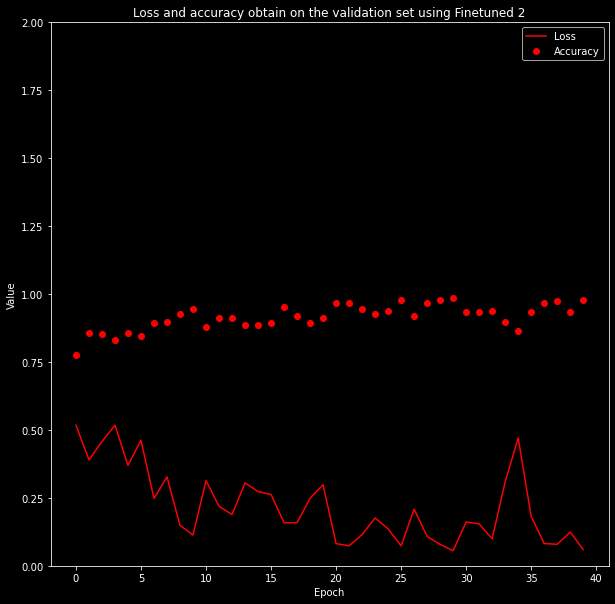

In [97]:
plotValResult(historyCategory2Finetuned, "Finetuned 2")

In [98]:
modelCategory2Finetuned.load_weights(modelCategory2Finetuned_checkpoint_filepath)

     - Clinical:

In [99]:
modelCategory2Clinical_checkpoint_filepath = "checkpoints/checkpointCategory2Clinical"
modelCategory2Clinical_checkpoint_callback = ModelCheckpoint(filepath=modelCategory2Clinical_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [100]:
historyCategory2Clinical = modelCategory2Clinical.fit(featuresClinical2_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory2Clinical_checkpoint_callback],
          validation_data=(featuresClinical2_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

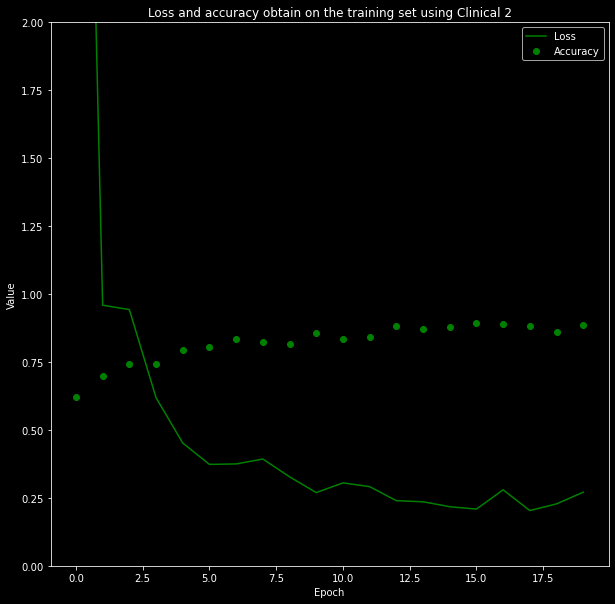

In [101]:
plotTrainResult(historyCategory2Clinical, "Clinical 2")

<Figure size 720x504 with 0 Axes>

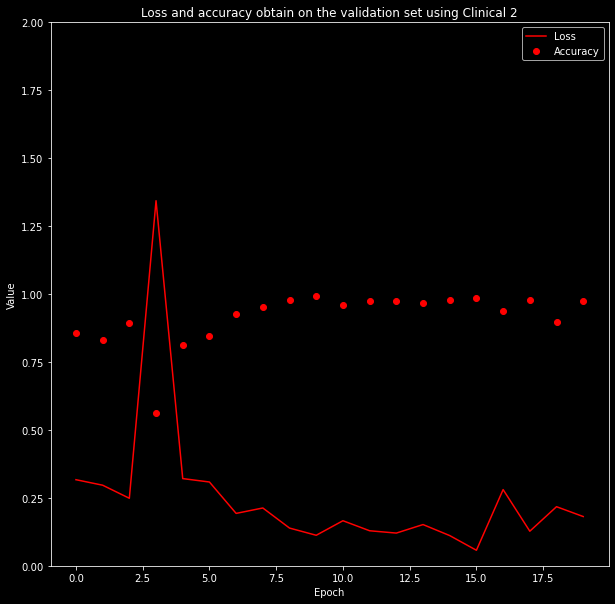

In [102]:
plotValResult(historyCategory2Clinical, "Clinical 2")

In [103]:
modelCategory2Clinical.load_weights(modelCategory2Clinical_checkpoint_filepath)

- 3. Models of third category:

    - Pretrained:

In [104]:
modelCategory3Pretrained_checkpoint_filepath = "checkpoints/checkpointCategory3Pretrained"
modelCategory3Pretrained_checkpoint_callback = ModelCheckpoint(filepath=modelCategory3Pretrained_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [105]:
historyCategory3Pretrained = modelCategory3Pretrained.fit(featuresPretrained3_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory3Pretrained_checkpoint_callback],
          validation_data=(featuresPretrained3_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

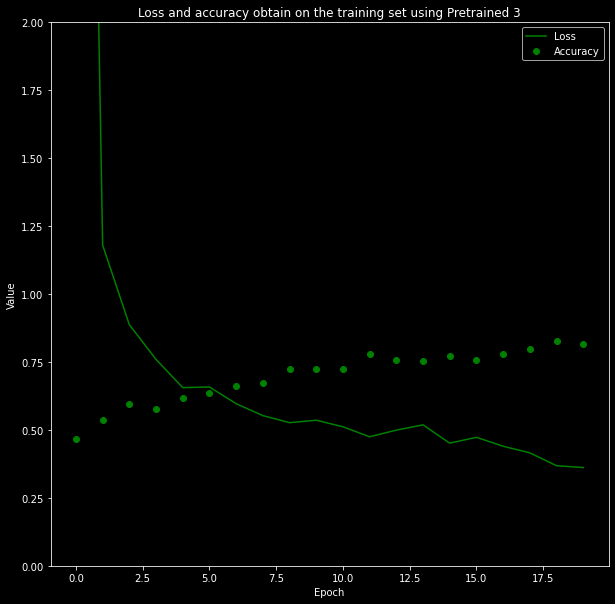

In [106]:
plotTrainResult(historyCategory3Pretrained, "Pretrained 3")

<Figure size 720x504 with 0 Axes>

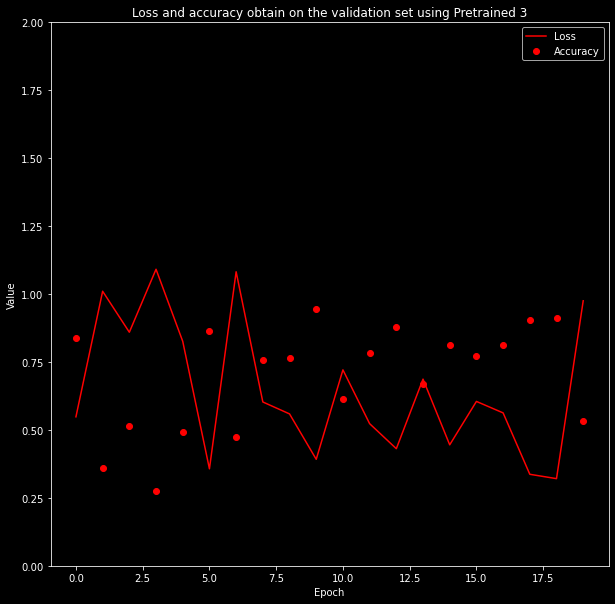

In [107]:
plotValResult(historyCategory3Pretrained, "Pretrained 3")

In [108]:
modelCategory3Pretrained.load_weights(modelCategory3Pretrained_checkpoint_filepath)

    - Finetuned:

In [109]:
modelCategory3Finetuned_checkpoint_filepath = "checkpoints/checkpointCategory3Finetuned"
modelCategory3Finetuned_checkpoint_callback = ModelCheckpoint(filepath=modelCategory3Finetuned_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [110]:
historyCategory3Finetuned = modelCategory3Finetuned.fit(featuresFinetuned3_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory3Finetuned_checkpoint_callback],
          validation_data=(featuresFinetuned3_validation, Y_validation))

<Figure size 720x504 with 0 Axes>

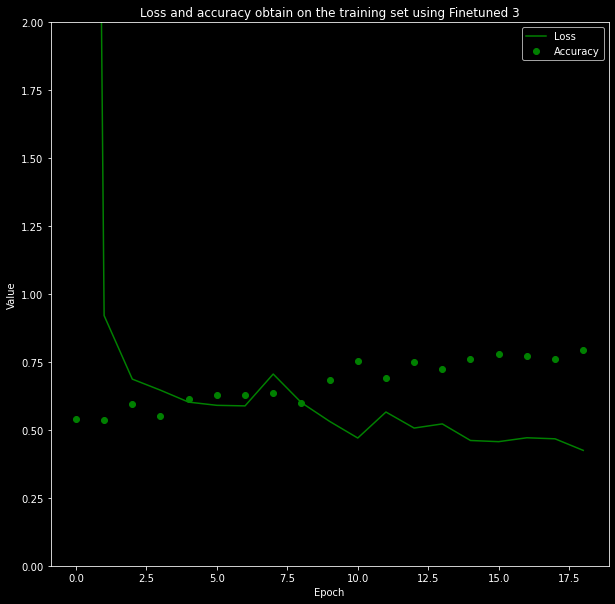

In [111]:
plotTrainResult(historyCategory3Finetuned, "Finetuned 3")

<Figure size 720x504 with 0 Axes>

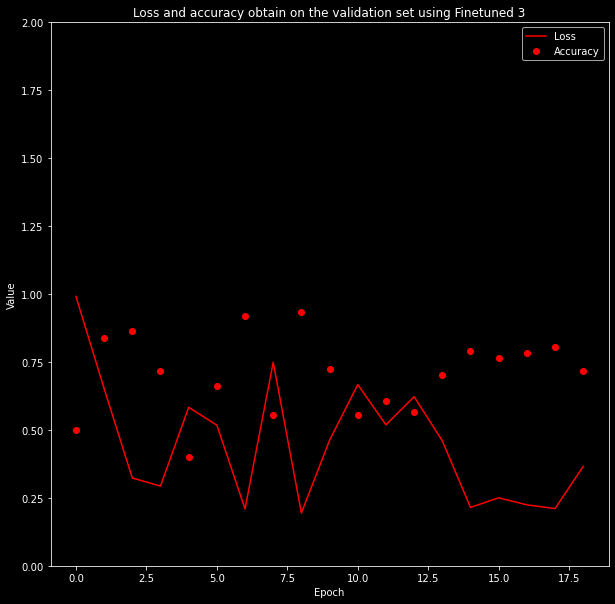

In [112]:
plotValResult(historyCategory3Finetuned, "Finetuned 3")

In [113]:
modelCategory3Finetuned.load_weights(modelCategory3Finetuned_checkpoint_filepath)

     - Clinical:

In [114]:
modelCategory3Clinical_checkpoint_filepath = "checkpoints/checkpointCategory3Clinical"
modelCategory3Clinical_checkpoint_callback = ModelCheckpoint(filepath=modelCategory3Clinical_checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max',  save_best_only=True)

In [ ]:
historyCategory3Clinical = modelCategory3Clinical.fit(featuresClinical3_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, modelCategory3Clinical_checkpoint_callback],
          validation_data=(featuresClinical3_validation, Y_validation))

In [ ]:
plotTrainResult(historyCategory3Clinical, "Clinical 3")

In [ ]:
plotValResult(historyCategory3Clinical, "Clinical 3")

In [ ]:
modelCategory3Clinical.load_weights(modelCategory3Clinical_checkpoint_filepath)

## Prediction
Finally, the models are used in order to obtain result.

- 1. Models from first category:

    - Pretrained:

In [ ]:
prediction = modelCategory1Pretrained.predict(featuresPretrained1_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Finetuned:

In [ ]:
prediction = modelCategory1Finetuned.predict(featuresFinetuned1_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Clinical:

In [ ]:
prediction = modelCategory1Clinical.predict(featuresClinical1_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

- 2. Models from second category:

    - Pretrained:

In [ ]:
prediction = modelCategory2Pretrained.predict(featuresPretrained2_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Finetuned:

In [ ]:
prediction = modelCategory2Finetuned.predict(featuresFinetuned2_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Clinical:

In [ ]:
prediction = modelCategory2Clinical.predict(featuresClinical2_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

- 3. Models from third category:

    - Pretrained:

In [ ]:
prediction = modelCategory3Pretrained.predict(featuresPretrained3_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Finetuned:

In [ ]:
prediction = modelCategory3Finetuned.predict(featuresFinetuned3_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))

    - Clinical:

In [ ]:
prediction = modelCategory3Clinical.predict(featuresClinical3_test)
prediction_classes = np.where(prediction > 0.5, 1, 0)
print('Accuracy: {:0.5f}'.format(accuracy_score(Y_test, prediction_classes)))